<a href="https://colab.research.google.com/github/israel-adewuyi/name_generator/blob/main/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
  Intuitive understanding and explanation of the hidden layer to the output
      layer.
  V1 - Each neuron in the hidden layer is saying something about each of the
      rows in the input matrix.

  * Cross entropy is obviously not the same as softmax. But F.cross_entropy
      calculates the softmax probabilities first, then handle the cross entropy
      loss. All we do is pass logits as well as the target output to the
      function.
      1. Forward pass is more efficient, no creation of new tensors and all is
          happening in 'fused' kernels
      2. Backward pass is also more efficient
      3. The outputs are numerically well-behaved, crossentropy does
          Logits - max(Logits), this prevents NaN with extremely large values
          of exp.



  (1, 90)(90, 100) --> (1, 100)
"""

In [137]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [138]:
words = open('names.txt', 'r').read().splitlines()

In [139]:
chars = sorted(list(set(''.join(words))))

chars_to_idx = {ch : i + 1 for i, ch in enumerate(chars)}
chars_to_idx['.'] = 0

idx_to_chars = {i : ch for ch, i in chars_to_idx.items()}

In [247]:
block_size = 3

def build_dataset(words):
  X, Y = [], []
  for name in words:
    # print(name)
    context = [0] * block_size

    for ch in name + '.':
      ix = chars_to_idx[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(idx_to_chars[x] for x in context), '--> {}'.format(ch))
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22740, 3]) torch.Size([22740])
torch.Size([22826, 3]) torch.Size([22826])


In [296]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 250), generator=g)
b1 = torch.randn((250), generator=g)
W2 = torch.randn((250, 27), generator=g)
b2 = torch.randn((27), generator=g)
parameters = [C, W1, b1, W2, b2]

In [297]:
sum(p.nelement() for p in parameters)

14797

In [298]:
for param in parameters:
  param.requires_grad = True

In [299]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [300]:
lri = []
stepi = []
lossi = []

In [307]:
for i in range(50000):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (50, ))

  #forward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])
  # print(loss.item())
  #backward pass
  for param in parameters:
    param.grad = None

  loss.backward()

  #Update
  # lr = lrs[i]
  lr = 0.005
  for param in parameters:
    param.data += -lr * param.grad

  # lri.append(lre[i])
  lossi.append(loss.item())
  stepi.append(i)

print(loss.item())

2.1232895851135254


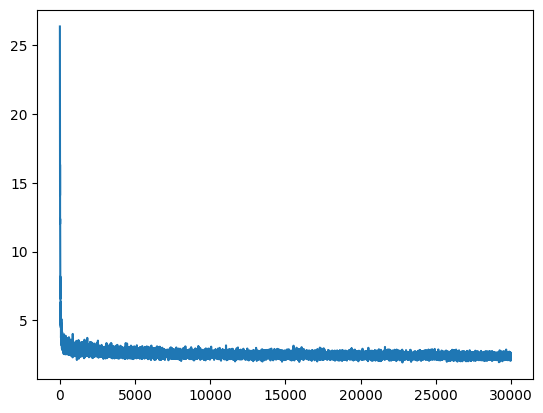

In [270]:
plt.plot(stepi, lossi)

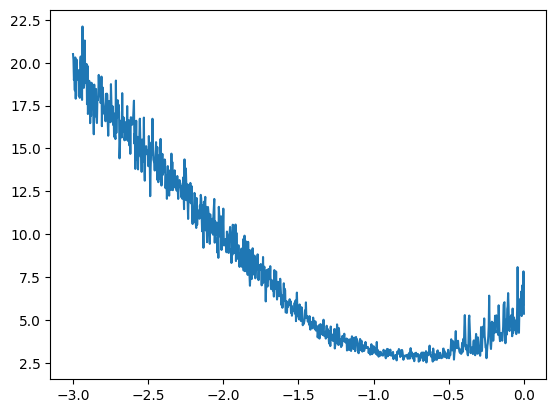

In [227]:
plt.plot(lri, lossi)

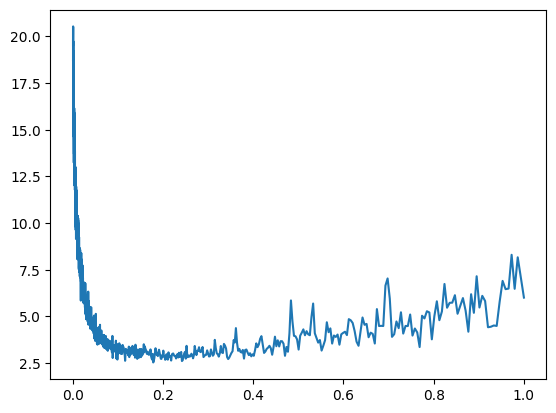

In [221]:
plt.plot(lri, lossi)

In [309]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.2084004878997803


In [308]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.17276930809021


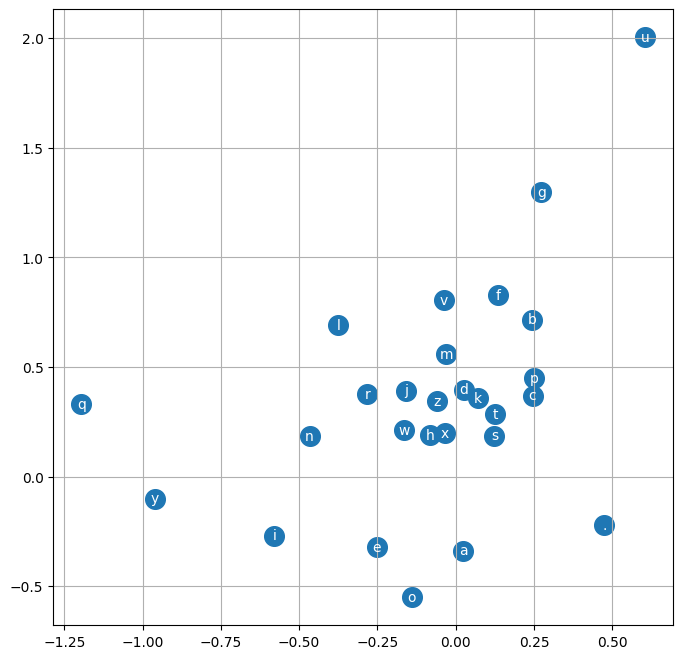

In [292]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), idx_to_chars[i], ha="center", va="center", color='white')
plt.grid('minor')

In [310]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(idx_to_chars[i] for i in out))

mora.
mayah.
see.
med.
ryam.
rethan.
emdrie.
cadered.
eliah.
milop.
leigh.
esmanaraylyn.
malke.
miyshaberg.
himie.
tri.
jowelle.
xateusa.
uberted.
ryyah.
